# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html


- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
- https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/


## Install

In [213]:
# !pip install numpy
# !pip install pandas

# !pip install sklearn
# !pip install joblib
# !pip install optuna

# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# !pip install matplotlib
# !pip install seaborn
# !pip install rfpimp
# !pip install skater
# !pip install eli5

## Init

In [214]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance


from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [215]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [216]:
# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# def absolute_score(y_true, y_pred):
#     return 1 - (np.sum(np.absolute(y_pred - y_true)) / np.sum(y_true))

# def show_pred(y_test, y_pred, xlabel, ylabel):
#     plt.figure(figsize=(8,6))
#     plt.scatter(y_pred, y_test)
#     plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

#     plt.show()


# def show_feature_importances(model, X, y):
#     model_name = type(model).__name__
#     importances = None

#     if hasattr(model, 'feature_importances_'):
#         importances = model.feature_importances_       
#     else:
#         perm = PermutationImportance(model, cv = None, refit = False).fit(X_train, y_train)
#         importances = perm.feature_importances_

#     sorted_idx = importances.argsort()

#     plt.figure(figsize=(8,6)) 
#     plt.barh(X.columns[sorted_idx], importances[sorted_idx])
#     plt.xlabel(f"{model_name} - Feature Importance")
#     plt.show()

# def reduce_mem_usage(df, ignoreCols=[], verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:    
#         if col in ignoreCols:
#             continue

#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df



In [217]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./train_results/{DATASET_NAME}_train_result.csv'
RESULT_EXCEL_PATH = f'./train_results/{DATASET_NAME}_train_result.xlsx'

MAX_N_JOBS = 8

## Load Data

In [218]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays = workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [219]:
data_dtype = {'SkuShort':'str', 'Brand':'str', 'Country':'str', 'IsLockdown':'bool'} #'ProductGroup':'str', 'PrimaryPack':'str',

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01000,PILSNER URQUELL,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1901.850666,2057.73,NaN,NaN,NaN,NaN,1902.0890
1,01000,PILSNER URQUELL,SK,2016,1,4,-1.164286,0.935714,1.014286,False,NaN,NaN,227.634836,240.00,NaN,NaN,NaN,NaN,155.0000
2,01002,PILSNER URQUELL,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,472.938882,394.50,NaN,NaN,NaN,NaN,375.6472
3,01002,PILSNER URQUELL,SK,2016,1,4,-1.164286,0.935714,1.014286,False,NaN,NaN,71.895601,49.80,NaN,NaN,NaN,NaN,29.9165
4,01003,PILSNER URQUELL,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,3010.971784,2535.60,NaN,NaN,NaN,NaN,2311.0085


In [220]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  1.54 Mb (59.3% reduction)


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27439 entries, 0 to 27438
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          27439 non-null  object 
 1   Brand             27439 non-null  object 
 2   Country           27439 non-null  object 
 3   Year              27439 non-null  int16  
 4   Week              27439 non-null  int8   
 5   NumberWorkdays    27439 non-null  int8   
 6   AvgTemp           27439 non-null  float16
 7   AvgRain           27439 non-null  float16
 8   AvgSun            27439 non-null  float16
 9   IsLockdown        27439 non-null  bool   
 10  PdtHl             526 non-null    float16
 11  PrevWeekPdtHl1    526 non-null    float16
 12  BgtHl             24429 non-null  float16
 13  SalesHl           24523 non-null  float64
 14  PrevWeekSalesHl1  24270 non-null  float16
 15  PrevWeekSalesHl2  24109 non-null  float16
 16  PrevYearSalesHl1  19460 non-null  float1

In [222]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,27439.000000,27439.000000,27439.000000,2.743900e+04,27439.000000,2.743900e+04,526.000000,526.000000,2.442900e+04,24523.000000,2.427000e+04,2.410900e+04,1.946000e+04,1.470100e+04,2.386000e+04
mean,2018.256350,25.717009,4.789242,inf,1.655273,inf,50.156250,50.156250,inf,646.299836,inf,inf,inf,inf,inf
std,1.575387,14.982245,0.493052,7.703125e+00,1.636719,3.037109e+00,inf,inf,inf,1499.138985,inf,inf,inf,inf,inf
min,2016.000000,1.000000,2.000000,-8.281250e+00,0.000000,1.428223e-01,0.300049,0.300049,5.960464e-08,0.050000,4.998779e-02,4.998779e-02,4.998779e-02,3.000488e-01,5.319214e-02
25%,2017.000000,13.000000,5.000000,4.000000e+00,0.471436,2.185547e+00,3.386719,3.386719,4.768750e+01,35.400000,3.631250e+01,3.659375e+01,4.381250e+01,4.793750e+01,3.934375e+01
50%,2018.000000,25.000000,5.000000,1.046875e+01,1.128906,4.792969e+00,14.179688,14.179688,1.712500e+02,135.000000,1.370000e+02,1.380000e+02,1.632500e+02,1.812500e+02,1.485000e+02
75%,2020.000000,39.000000,5.000000,1.768750e+01,2.271484,7.144531e+00,34.375000,34.375000,5.760000e+02,512.850000,5.155000e+02,5.165000e+02,5.725000e+02,5.990000e+02,5.280000e+02
max,2021.000000,53.000000,5.000000,2.581250e+01,7.957031,1.386719e+01,625.000000,625.000000,1.460000e+04,17816.500000,1.782400e+04,1.782400e+04,1.782400e+04,1.782400e+04,1.504800e+04


## Missing Values

In [223]:
data.isna().sum()

SkuShort            0    
Brand               0    
Country             0    
Year                0    
Week                0    
NumberWorkdays      0    
AvgTemp             0    
AvgRain             0    
AvgSun              0    
IsLockdown          0    
PdtHl               26913
PrevWeekPdtHl1      26913
BgtHl               3010 
SalesHl             2916 
PrevWeekSalesHl1    3169 
PrevWeekSalesHl2    3330 
PrevYearSalesHl1    7979 
PrevYearSalesHl2    12738
OldPredSalesHl      3579 
dtype: int64

## Data Visualizations

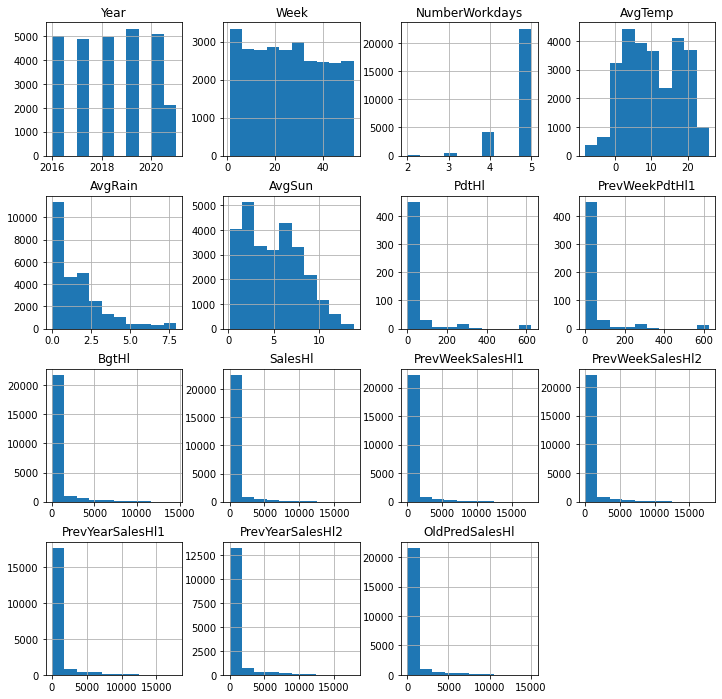

In [224]:
data.hist(figsize=[12,12])
plt.show()

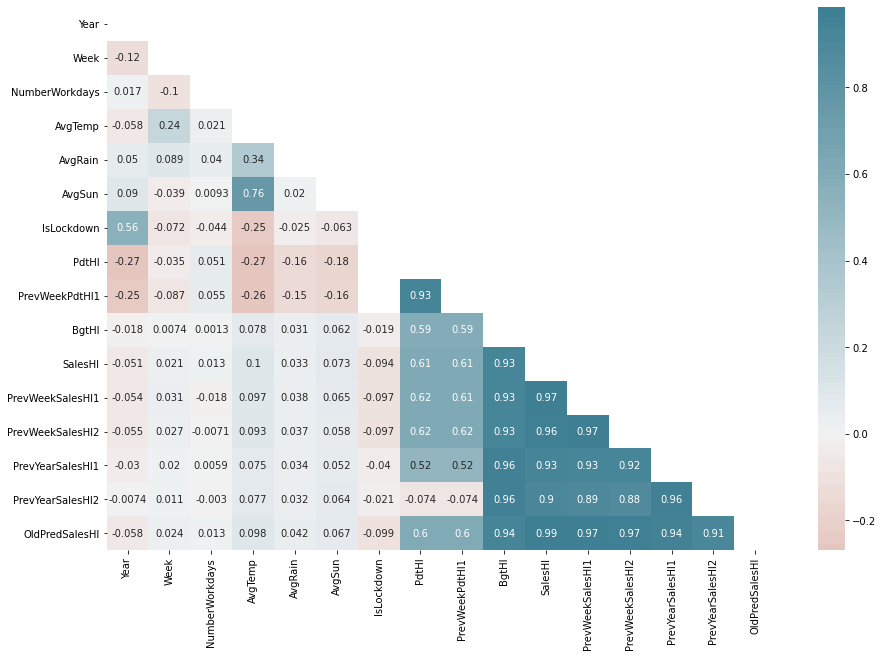

In [225]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [226]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.986064
PrevWeekSalesHl1,0.972606
PrevWeekSalesHl2,0.963176
PrevYearSalesHl1,0.934875
BgtHl,0.931478
PrevYearSalesHl2,0.904542
PdtHl,0.612812
PrevWeekPdtHl1,0.612127
AvgTemp,0.099775


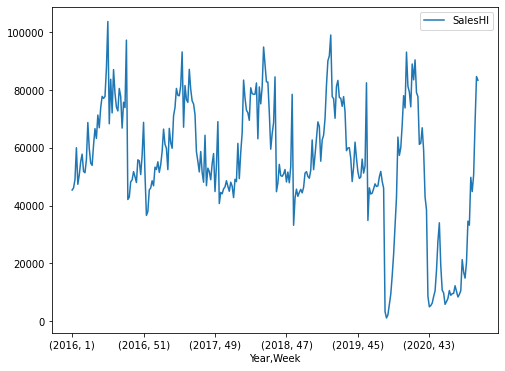

In [227]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

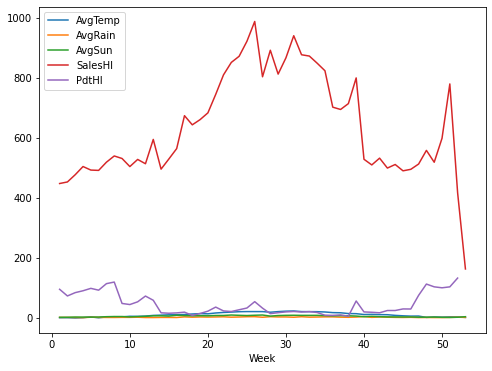

In [228]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

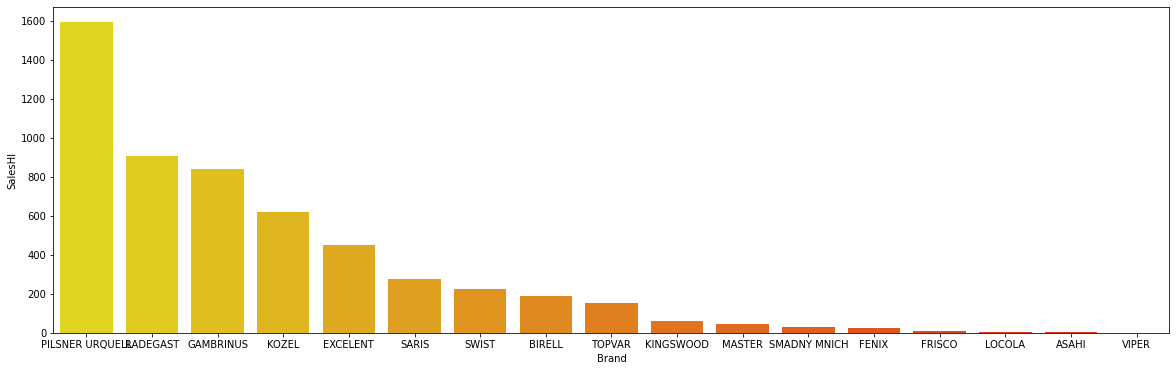

In [229]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [230]:
data.skew()

SkuShort            1.804895
Year                0.056379
Week                0.085803
NumberWorkdays     -2.671343
AvgTemp            -inf     
AvgRain             inf     
AvgSun              inf     
IsLockdown          2.091118
PdtHl               3.875000
PrevWeekPdtHl1      3.875000
BgtHl               inf     
SalesHl             4.243672
PrevWeekSalesHl1    inf     
PrevWeekSalesHl2    inf     
PrevYearSalesHl1    inf     
PrevYearSalesHl2    inf     
OldPredSalesHl      inf     
dtype: float64

In [231]:
data.kurt()

SkuShort            4.185648 
Year               -1.154129 
Week               -1.181763 
NumberWorkdays      8.247936 
AvgTemp            NaN       
AvgRain            NaN       
AvgSun             NaN       
IsLockdown          2.372949 
PdtHl              NaN       
PrevWeekPdtHl1     NaN       
BgtHl              NaN       
SalesHl             20.795707
PrevWeekSalesHl1   NaN       
PrevWeekSalesHl2   NaN       
PrevYearSalesHl1   NaN       
PrevYearSalesHl2   NaN       
OldPredSalesHl     NaN       
dtype: float64

## Spliting data in X and Y

In [232]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

In [233]:
# X['NextWeek'] = X['Week']+1
# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.drop(['NextWeek',  'WeekNext'], axis=1) 
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)

# X['PrevWeek'] = X['Week']-1
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))
# X = X.drop(['PrevWeek', 'WeekPrev', ], axis=1) #'NextWeek',  'WeekNext'
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)

X['NextWeek'] = X['Week']+1
X['PrevWeek'] = X['Week']-1

X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

X = X.drop(['PrevWeek', 'WeekPrev', 'NextWeek',  'WeekNext'], axis=1)
X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,01000,PILSNER URQUELL,CZ,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1902.000000,NaN,NaN,NaN,NaN,5.0,5.0
1,01000,PILSNER URQUELL,SK,2016,1,4,-1.164062,0.935547,1.014648,False,NaN,NaN,227.625000,NaN,NaN,NaN,NaN,5.0,5.0
2,01002,PILSNER URQUELL,CZ,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,473.000000,NaN,NaN,NaN,NaN,5.0,5.0
3,01002,PILSNER URQUELL,SK,2016,1,4,-1.164062,0.935547,1.014648,False,NaN,NaN,71.875000,NaN,NaN,NaN,NaN,5.0,5.0
4,01003,PILSNER URQUELL,CZ,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,3010.000000,NaN,NaN,NaN,NaN,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27434,15202,KINGSWOOD,CZ,2021,24,5,22.296875,0.065918,13.250000,False,NaN,NaN,4.195312,NaN,NaN,NaN,18.359375,5.0,5.0
27435,17501,VIPER,CZ,2021,24,5,22.296875,0.065918,13.250000,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
27436,20105,SWIST,CZ,2021,24,5,22.296875,0.065918,13.250000,False,NaN,NaN,204.250000,179.0,134.0,138.0,259.500000,5.0,5.0
27437,20205,SWIST,CZ,2021,24,5,22.296875,0.065918,13.250000,False,NaN,NaN,669.500000,685.0,375.0,320.5,835.000000,5.0,5.0


## LabelEncoder

In [234]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

sku_encoder = LabelEncoder()
X.SkuShort = sku_encoder.fit_transform(X.SkuShort)

brand_encoder = LabelEncoder()
X.Brand = brand_encoder.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0,10,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1902.000,NaN,NaN,NaN,NaN,5.0,5.0
1,0,10,2,2016,1,4,-1.164062,0.935547,1.014648,False,NaN,NaN,227.625,NaN,NaN,NaN,NaN,5.0,5.0
2,2,10,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,473.000,NaN,NaN,NaN,NaN,5.0,5.0
3,2,10,2,2016,1,4,-1.164062,0.935547,1.014648,False,NaN,NaN,71.875,NaN,NaN,NaN,NaN,5.0,5.0
4,3,10,1,2016,1,5,-1.164062,0.935547,1.014648,False,NaN,NaN,3010.000,NaN,NaN,NaN,NaN,5.0,5.0


## Imputer

In [235]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [236]:
imputer = SimpleImputer(strategy='mean')
# si = SimpleImputer(strategy='constant', fill_value=0)
# si = IterativeImputer(random_state=0, skip_complete=True, min_value=0)
# si = KNNImputer()

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
1,0.0,10.0,2.0,2016.0,1.0,4.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,227.625000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
2,2.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
3,2.0,10.0,2.0,2016.0,1.0,4.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,71.875000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
4,3.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27434,117.0,6.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,4.195312,649.619645,650.752694,709.045507,18.359375,5.0,5.0
27435,120.0,16.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0
27436,121.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,204.250000,179.000000,134.000000,138.000000,259.500000,5.0,5.0
27437,122.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,669.500000,685.000000,375.000000,320.500000,835.000000,5.0,5.0


## Adding a New Feature

In [237]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,1902.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
1,0.0,10.0,2.0,2016.0,1.0,4.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,227.625000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
2,2.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,473.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
3,2.0,10.0,2.0,2016.0,1.0,4.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,71.875000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
4,3.0,10.0,1.0,2016.0,1.0,5.0,-1.164062,0.935547,1.014648,0.0,0.0,0.0,3010.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27434,117.0,6.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,4.195312,649.619645,650.752694,709.045507,18.359375,5.0,5.0,650.2,363.7,506.9
27435,120.0,16.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,0.000000,649.619645,650.752694,709.045507,749.326224,5.0,5.0,650.2,729.2,689.7
27436,121.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,204.250000,179.000000,134.000000,138.000000,259.500000,5.0,5.0,156.5,198.8,177.6
27437,122.0,14.0,1.0,2021.0,24.0,5.0,22.296875,0.065918,13.250000,0.0,0.0,0.0,669.500000,685.000000,375.000000,320.500000,835.000000,5.0,5.0,530.0,577.8,553.9


## Split train and test

In [238]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 15))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [239]:
# transformers = [
#     ("ignore1", 'passthrough', ['SkuShort','Brand','Country','Year','Week','NumberWorkdays']),
#     ("num1", StandardScaler(), ['AvgTemp', 'AvgRain', 'AvgSun']),
#     ("ignore2", 'passthrough', ['IsLockdown']),
#     ("num2", StandardScaler(), ['PdtHl', 'PrevWeekPdtHl1', 'BgtHl', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2', 'PrevYearSalesHl1','PrevYearSalesHl2']),
#     ("ignore3", 'passthrough', ['NumberWorkdaysNext', 'NumberWorkdaysPrev']),
#     ("num3", StandardScaler(), ['AvgPrevWeekSalesHl','AvgPrevYearSalesHl','AvgPrevAllSalesHl']),
# ]

# transformer = ColumnTransformer(transformers = transformers)

# X = pd.DataFrame(transformer.fit_transform(X), columns=X.columns)
# X

In [240]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler() 
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,-1.621878,0.570809,-0.959387,-1.425697,-1.641227,0.436407,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,0.887868,-0.002440,-0.003734,-0.004244,0.001672,0.41299,0.428675,-0.003103,-0.001537,-0.002529
1,-1.621878,0.570809,1.042332,-1.425697,-1.641227,-1.563231,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.275221,-0.002440,-0.003734,-0.004244,0.001672,0.41299,0.428675,-0.003103,-0.001537,-0.002529
2,-1.561486,0.570809,-0.959387,-1.425697,-1.641227,0.436407,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.104773,-0.002440,-0.003734,-0.004244,0.001672,0.41299,0.428675,-0.003103,-0.001537,-0.002529
3,-1.561486,0.570809,1.042332,-1.425697,-1.641227,-1.563231,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,-0.383411,-0.002440,-0.003734,-0.004244,0.001672,0.41299,0.428675,-0.003103,-0.001537,-0.002529
4,-1.531291,0.570809,-0.959387,-1.425697,-1.641227,0.436407,-1.474544,-0.435890,-1.282881,-0.374681,-0.057901,-0.057901,1.657530,-0.002440,-0.003734,-0.004244,0.001672,0.41299,0.428675,-0.003103,-0.001537,-0.002529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26493,1.850646,-0.483237,-0.959387,1.876182,-0.785483,-1.563231,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.413074,-0.457218,-0.461015,-0.537798,-0.617724,0.41299,-1.951675,-0.462787,-0.602852,-0.559280
26494,1.880841,-0.483237,-0.959387,1.876182,-0.785483,-1.563231,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.359533,-0.448717,-0.460291,-0.004244,-0.575328,0.41299,-1.951675,-0.458106,-0.284780,-0.401957
26495,2.031821,1.624854,-0.959387,1.876182,-0.785483,-1.563231,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.289548,-0.452443,-0.458250,-0.537883,-0.502129,0.41299,-1.951675,-0.458957,-0.546203,-0.529497
26496,2.062017,1.624854,-0.959387,1.876182,-0.785483,-1.563231,-0.707962,-0.542925,0.332855,2.668939,-0.057901,-0.057901,-0.102863,-0.435558,-0.452267,-0.536000,-0.367486,0.41299,-1.951675,-0.447396,-0.479064,-0.490247


## Regressors

In [241]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

#model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, reg_lambda=20, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

## Find best params

In [242]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart',  importance_type='gain', reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

# param_grid = dict(base_score =[ 0.25, 0.3, 0.35, 0.4,]) #importance_type=['gain', 'weight', 'cover','total_gain','total_cover']
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train)
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [243]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)#0.9168

# # Train the model using the training sets
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# print(DATASET_NAME)
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
# print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
# print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
# print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

## Models

### HistGradientBoostingRegressor 

In [244]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [245]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [246]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [247]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [248]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [249]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [250]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [251]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel] #xgbModel
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=8,
                       oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True)]

In [252]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 2min 14s


In [253]:
col_metric = 'AbsoluteScore'
max_score = result_models[col_metric].max()
min_score = result_models[col_metric].min()
min_weight = min_score - ((max_score - min_score) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (max_score - min_weight), 2))
result_models.sort_values(by=[col_metric], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
1,CatBoostRegressor,0.967902,0.817063,2400.224615,51952.202055,94.320442,1.00
3,RandomForestRegressor,0.939944,0.796155,3848.239709,97205.211571,105.100516,0.56
2,HistGradientBoostingRegressor,0.951574,0.791452,2471.468201,78381.784208,107.525261,0.46
4,ExtraTreesRegressor,0.940044,0.791291,3409.719885,97043.797579,107.608188,0.46
0,LGBMRegressor,0.946465,0.777652,2951.183499,86649.677521,114.640118,0.17


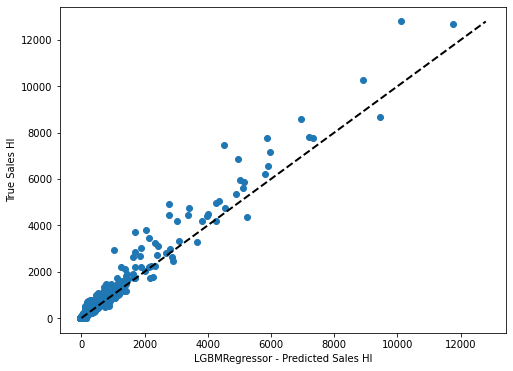

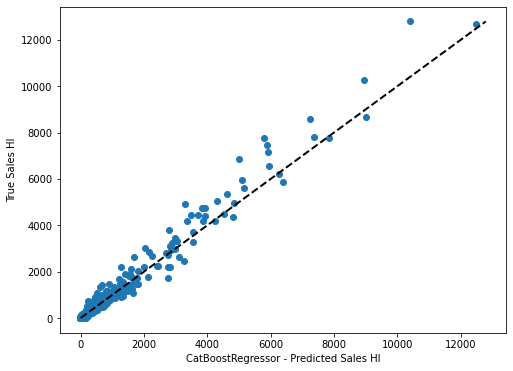

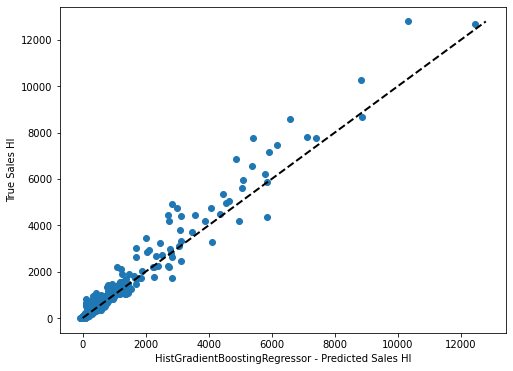

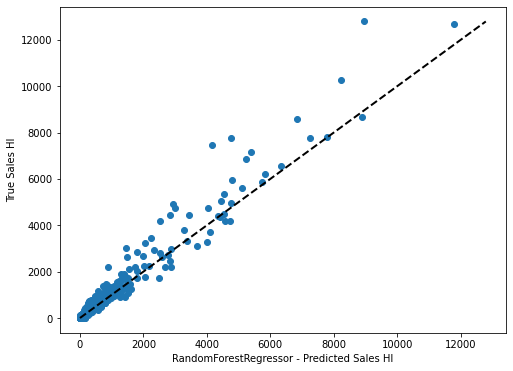

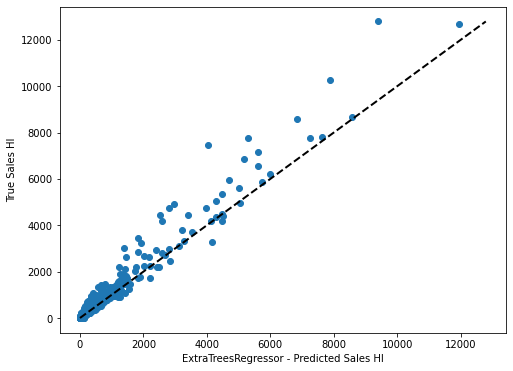

In [254]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

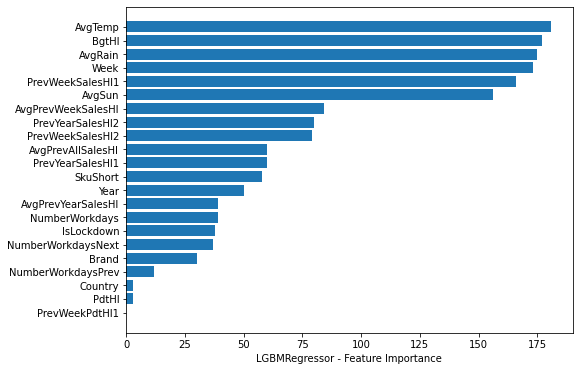

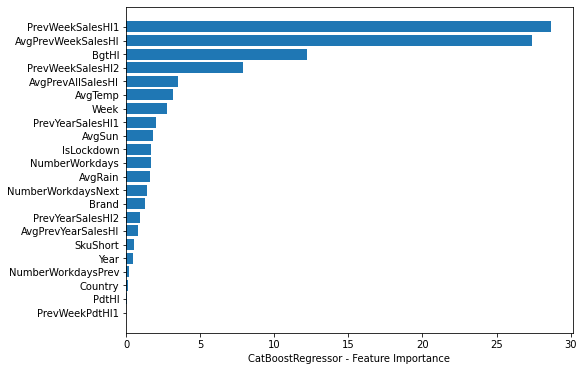

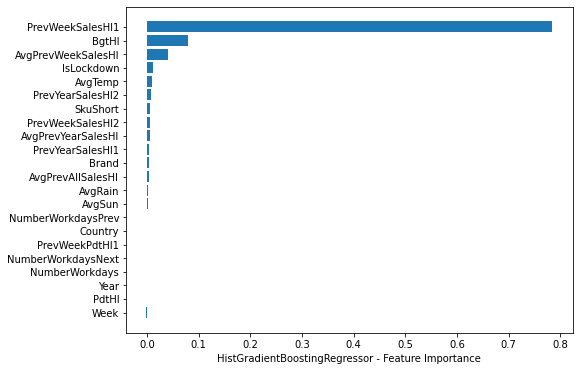

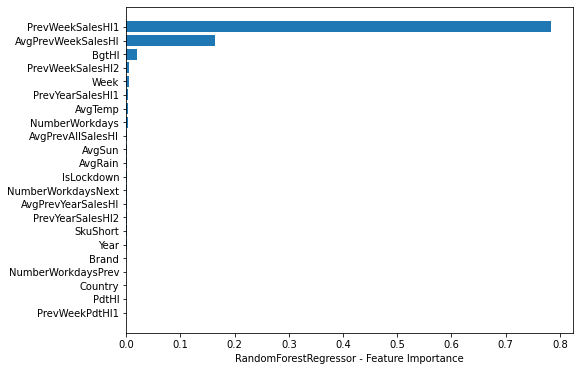

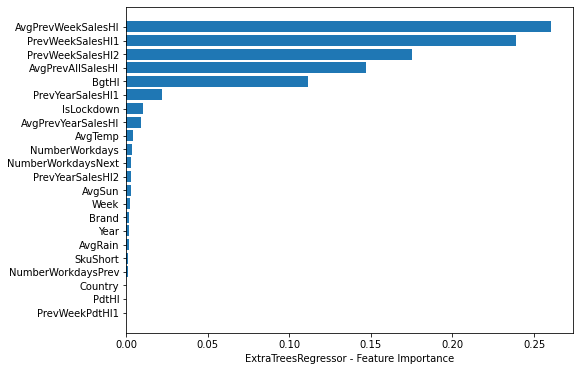

In [255]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [256]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

Wall time: 2min 24s


In [257]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


on-trade
----------------
Coefficient of determination: 0.9577
Absolute Score: 0.8132
Mean absolute error regression loss.: 96.2956
Maximum residual error: 2872.5000
Mean squared error regression loss: 68485.7369
----------------
Classic Coefficient of determination: 0.9432
Classic Absolute Score: 0.7722
Classic Mean absolute error regression loss.: 117.4669
Classic Maximum residual error: 3395.5000
Classic Mean squared error regression loss: 91932.6711


In [258]:
# on-trade
# ----------------
# Coefficient of determination: 0.9514
# Absolute Score: 0.8130
# Mean absolute error regression loss.: 108.1275
# Maximum residual error: 3125.5000
# Mean squared error regression loss: 86452.0914
# Model	Score	AbsoluteScore	ME	MSE	MAE	Weights
# 2	HistGradientBoostingRegressor	0.955358	0.806730	2989.837491	79421.959497	111.762361	1.00
# 1	CatBoostRegressor	0.957084	0.804909	2901.411474	76351.785402	112.815537	0.97
# 3	RandomForestRegressor	0.934811	0.796599	3901.524718	115978.444476	117.620760	0.82
# 4	ExtraTreesRegressor	0.939267	0.794882	3657.853600	108049.644122	118.613685	0.79
# 0	LGBMRegressor	0.945340	0.788665	3373.762636	97245.555958	122.208870	0.68
# 5	XGBRegressor	0.934536	0.759017	3328.271484	116466.989397	139.353311	0.17



# off-trade
# ----------------
# Coefficient of determination: 0.8556
# Absolute Score: 0.6448
# Mean absolute error regression loss.: 253.1794
# Maximum residual error: 5776.5000
# Mean squared error regression loss: 374444.6970
# Model	Score	AbsoluteScore	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.859157	0.643559	5638.776628	365207.529730	254.062583	1.00
# 3	RandomForestRegressor	0.849229	0.635457	6171.195664	390950.983010	259.837717	0.84
# 2	HistGradientBoostingRegressor	0.834710	0.634234	6580.492142	428597.808705	260.709429	0.82
# 4	ExtraTreesRegressor	0.848456	0.633534	5635.769449	392954.107209	261.208381	0.81
# 0	LGBMRegressor	0.835141	0.627109	6274.090869	427480.223571	265.787598	0.68
# 5	XGBRegressor	0.803034	0.600191	9424.666602	510733.555643	284.974211	0.17


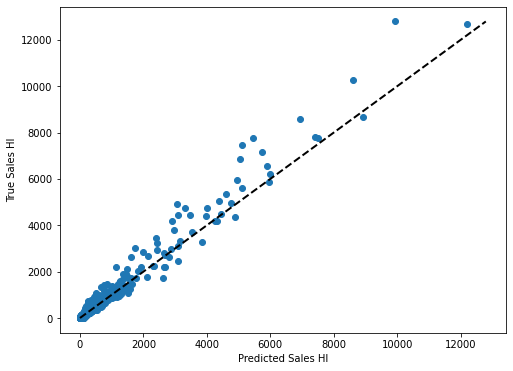

In [259]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

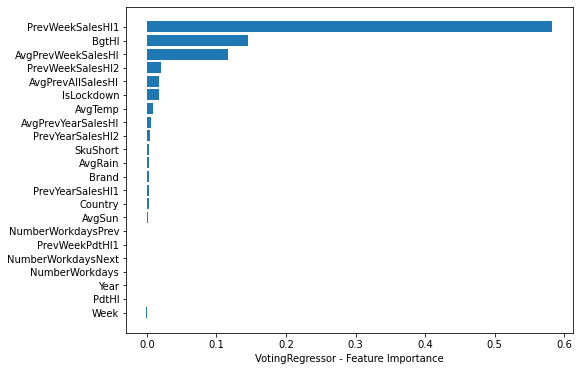

Wall time: 30.7 s


In [260]:
%%time

show_feature_importances(model, X_test, y_test)

## Save Result

In [261]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [262]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(sku_encoder, SKU_ENCODER_PATH)
joblib.dump(brand_encoder, BRAND_ENCODER_PATH)

['./models/on-trade_brand_encoder.joblib']